In [120]:
pip install tifffile

Note: you may need to restart the kernel to use updated packages.


In [121]:
pip install wand

     |████████████████████████████████| 138 kB 4.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [125]:
import numpy as np
import os
import tifffile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import wand

from PIL import Image
from sklearn.ensemble import RandomForestClassifier

## Load in the images and generate the training data

In [75]:
data_dir = "parry_town_train_aoi_2_64/"
image_dir = data_dir + "sentinel_raster_maps/"
target_dir = data_dir + "target_raster_maps/"

no_images = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(image_dir))))
    
no_targets = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(target_dir))))

assert no_images == no_targets

images = []
targets = []

shp = tifffile.imread("{}image_{}.tiff".format(image_dir, "0")).shape
tilesize = shp[0]
no_bands = shp[2]

X = np.empty((tilesize**2*no_images, no_bands))
y = np.empty(tilesize**2*no_images)

for i in range(no_images):
    #Sentinel band (image) raster - X
    image_data = tifffile.imread("{}image_{}.tiff".format(image_dir, i))
    images.append(image_data)
    
    X[i*tilesize**2:(i+1)*tilesize**2, :] = np.reshape(image_data, (tilesize**2, no_bands))
    
    #Target raster - y
    target = Image.open("{}target_{}.tiff".format(target_dir, i))
    #print(np.array(target.getdata()).shape)
    targets.append(np.reshape(list(target.getdata()), (tilesize, tilesize)))
    
    y[i*tilesize**2:(i+1)*tilesize**2] = np.array(target.getdata())
    
y = y.astype(int)
    
print(X.shape)
print(y.shape)
np.unique(y, return_counts = True)

(40960, 10)
(40960,)


(array([0, 1]), array([38131,  2829]))

## Plot some samples of the training data

In [76]:
no_images = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(data_dir + "sentinel_raster_maps/"))))
img_iterator = iter(range(no_images))

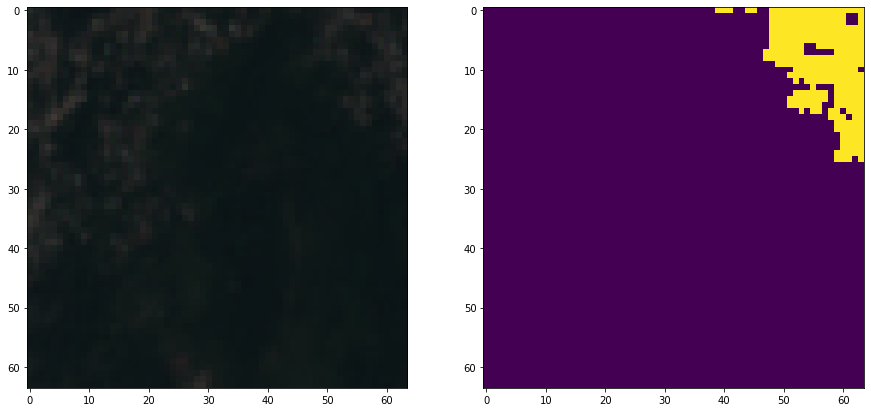

In [77]:
fig, ax = plt.subplots(1,2, figsize = (15,15))

i = next(img_iterator)

a_target = Image.open('{}/target_{}.tiff'.format(target_dir, i)) #tifffile complains about codecs if you try to use that here
img_size = int(np.sqrt(len(list(a_target.getdata()))))
target_pixel_data = np.reshape(list(a_target.getdata()), (img_size,img_size))
ax[1].imshow(target_pixel_data)

a_image = tifffile.imread("{}/image_{}.tiff".format(image_dir, i))
image_pixel_data = a_image[:,:,0:3] #RGB Selected as bands 1:3
ax[0].imshow(image_pixel_data)

## Train a random forest classifier

In [104]:
rf_classifier = RandomForestClassifier(random_state = 0, class_weight = "balanced_subsample", max_depth=13, min_samples_split=5)
rf_classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=13, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [116]:
test_image = np.array(tifffile.imread('{}/image_0.tiff'.format("parry_town_large_aoi_512/sentinel_raster_maps")))

target_truth = Image.open('{}/target_0.tiff'.format("parry_town_large_aoi_512/target_raster_maps")) #tifffile complains about codecs if you try to use that here
img_size = int(np.sqrt(len(list(target_truth.getdata()))))
target_y = np.reshape(list(target_truth.getdata()), (img_size,img_size))



test_X = np.reshape(test_image, (test_image.shape[0]**2, no_bands))
test_y = rf_classifier.predict(test_X)#[:,0]

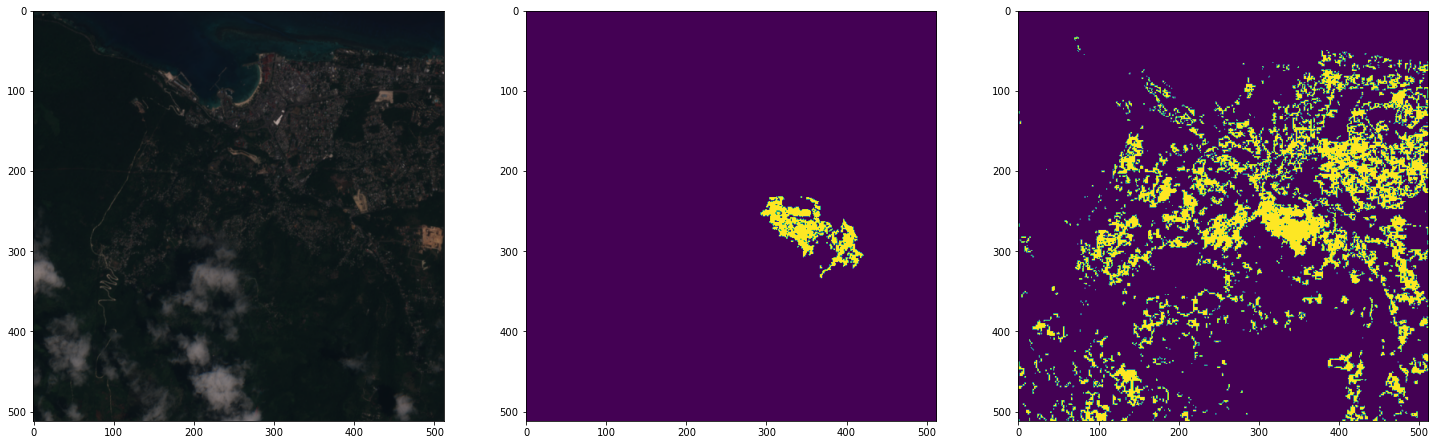

In [131]:
test_target_out = np.reshape(test_y, (test_image.shape[0], test_image.shape[0], 1))

fig2, ax2 = plt.subplots(1,3, figsize = (25,25))
ax2[0].imshow(test_image[:,:,0:3])
ax2[1].imshow(target_y)
ax2[2].imshow(test_target_out[:,:,0])